#### 5.1 SURPRISE 패키지 사용

In [1]:
import numpy as np

In [2]:
from surprise import BaselineOnly
from surprise import KNNWithMeans
from surprise import SVD
from surprise import SVDpp
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

- MovieLense 100k 데이터 불러오기

In [3]:
data = Dataset.load_builtin('ml-100k')

- train : test set을 0.75 : 0.25로 분리한다.

In [4]:
trainset,testset = train_test_split(data,test_size=0.25)

In [5]:
algo = KNNWithMeans()

KNNWithMeans 알고리즘을 사용한다.

In [6]:
algo.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


train set을 사용해서 학습한다.

In [7]:
predictions = algo.test(testset)

위에서 학습된 모델로 test set에 대한 예측치를 산출한다.

In [8]:
accuracy.rmse(predictions)

RMSE: 0.9500


0.9499987319280286

정확도(RMSE)를 계산한다.

#### 5.2 알고리즘 비교

In [9]:
algorithms = [BaselineOnly,KNNWithMeans,SVD,SVDpp]
names=[]
results=[]
for option in algorithms:
    # 현재알고리즘을 지정
    algo = option()
    # 알고리즘 이름
    names.append(option.__name__)
    algo.fit(trainset)
    predictions = algo.test(testset)
    # scikit-learn에서 fit_predict를 하는것처럼 여기서는 fit_test를 한다.
    results.append(accuracy.rmse(predictions))
    
# 그래프로 작성하기 위해 numpy array로 바꿔준다.a
names = np.array(names)
results = np.array(results)

Estimating biases using als...
RMSE: 0.9438
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9500
RMSE: 0.9369
RMSE: 0.9192


- 결과를 그래프로 표시

In [10]:
import matplotlib.pyplot as plt

array([0.91922144, 0.93685347, 0.94383269, 0.94999873])

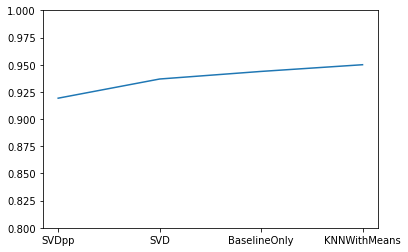

In [11]:
index = np.argsort(results)
plt.ylim(0.8,1)
plt.plot(names[index],results[index])
results[index]

 알고리즘 중에서 SVDpp가 RMSE=0.9234831로 가장 정확하고 KNNWithMeans가 RMSE=0.95109685로 가장 정확도가 낮다.

#### 5.3 알고리즘 옵션 지정
    surprise의 공식문서를 확인해보면 KNN CF 알고맂므에서 이웃 크기의 기본값은 40, 유사도지표의 기본값은 MSD(Mean Squared Deviation=MeanSquaredError)임을 알 수 있다.

- 알고리즘  옵션 변경, 정확도 계산

In [12]:
sim_options ={'name':'pearson_baseline','user_based':True}
# 알고리즘과 정확도 계산 옵션을 dictionary 형식으로 지정한다. 옵션은 알고리즘의 종류에 따라 조금씩 차이가 있는데 KNN의 경우,
# 'name'에는 유사도 지표의 종류를 지정한다. 유사도 종류에는 cosine,msd,pearson,pearson_baseline이 있다. 'user_based'가 True이므로 
# User_based CF(UBCF) 알고리즘을 사용한다. 만일 False라면 Item_Based CF(IBCF)알고리즘을 사용한다.
algo = KNNWithMeans(k=30,sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9396


0.9395590541237807

 이 코드를 실행하면 앞서 rmse가 0.95쯤에 있었던것에 비해 성능이 개선된 것을 알수 있다.

#### 5.4 최적의 이웃 크기 찾기

최적의 이웃크기를 찾기 위해서는 반복문을 이용하여 rmse를 비교후 제일 낮은 rmse를 도출하는 이웃크기를 찾으면 된다.

In [13]:
result = []

for neighbor_size in np.arange(10,61,10):
    algo = KNNWithMeans(k=neighbor_size,sim_options={'name':'pearson_baseline','user_based':True})
    algo.fit(trainset)
    predictions = algo.test(testset)
    result.append([neighbor_size,accuracy.rmse(predictions)])
    
result

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9522
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9406
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9396
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9392
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9394
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9397


[[10, 0.9522494399194379],
 [20, 0.9405741906024342],
 [30, 0.9395590541237807],
 [40, 0.939170523274545],
 [50, 0.9393609598315811],
 [60, 0.9397338903010872]]

In [14]:
index=[]
for i in result:
    index.append(i[0])
    
index

[10, 20, 30, 40, 50, 60]

Text(0.5, 1.0, '이웃의 수에 따른 knnmeans의 성능 추이')

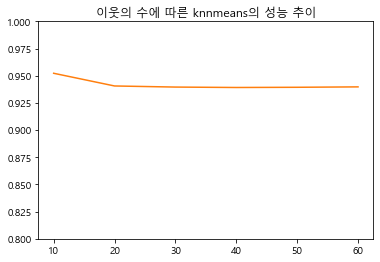

In [15]:
plt.rc('font',family='Malgun Gothic')
plt.ylim(0.8,1)
plt.plot(index,result)
plt.title('이웃의 수에 따른 knnmeans의 성능 추이')

이처럼 k만 조절하는 것이 아니라 각 k를 유저기반 cf와 아이템기반 cf와 조합해서 최적의 rmse를 찾기는 번거롭다.   
그렇기 때문에 사이킷런에서 gridseacrcv를 제공하는 것처럼 surprise에서도 grid search를 지원한다.

In [16]:
from surprise.model_selection import GridSearchCV
params = {'k':np.arange(5,26,5).tolist(),'sim_options':{'name':['pearson_baseline','cosine'],'user_based':[True,False]}}
gs = GridSearchCV(KNNWithMeans,params,measures=['rmse'],cv=4)
gs.fit(data)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similar

- 최적 RMSE 출력과 최고의 파라미터 출력(scikit-learn과 거의 비슷하게 진행된다.)

In [17]:
print(gs.best_score['rmse'])

0.9261494845395007


In [18]:
print(gs.best_params['rmse'])

{'k': 25, 'sim_options': {'name': 'pearson_baseline', 'user_based': False}}


#### 5.5 외부 데이터 사용

 지금까지는 Surprise에 내장되어 있는 데이터를 사용했는데, 경우에 따라서는 외부의 데이터를 읽어와야 할 경우도 있을 수 있다.  
 외부데이터는 surprise의read클래스를 사용하면 읽어올 수 있다.

In [19]:
from surprise import Reader
import pandas as pd

In [20]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('u.data', names=r_cols,  sep='\t',encoding='latin-1')
reader = Reader(rating_scale=(1,5))
# 평가 척도가 1에서 5까지임을 지정한다.
data = Dataset.load_from_df(ratings[['user_id', 'movie_id','rating']], reader)
# Surprise의 Dataset 클래스로 데이터를 읽어온다.

In [21]:
trainset, testset = train_test_split(data, test_size=0.25)

In [22]:
algo = KNNWithMeans()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9506


0.9506480949612895

In [23]:
predictions

[Prediction(uid=181, iid=886, r_ui=1.0, est=1.1319355054393152, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=262, iid=432, r_ui=3.0, est=3.5365055319996452, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=756, iid=1652, r_ui=1.0, est=2.4748563218390807, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid=209, iid=898, r_ui=3.0, est=2.5439194936672562, details={'actual_k': 33, 'was_impossible': False}),
 Prediction(uid=347, iid=137, r_ui=2.0, est=3.7001107821838795, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=286, iid=42, r_ui=4.0, est=3.6937550145707467, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=295, iid=22, r_ui=4.0, est=4.814448944074766, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=559, iid=205, r_ui=5.0, est=3.95732081201622, details={'actual_k': 40, 'was_impossible': False}),
 Prediction(uid=64, iid=182, r_ui=4.0, est=3.8287900710098013, details={'actu